### Neural Net with TensorFlow

In [ ]:
# Install tensorflow and protobuf -- run once!
# anaconda install instructions: https://www.tensorflow.org/install/install_mac

# # For chase's macbook, the following shell commands worked (take out ! if in terminal)
# !conda create -n tensorflow python=2.7
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.4.0-py2-none-any.whl

# Remember to activate container when you want to use package

In [29]:
import sys, csv, json
import requests
import numpy as np
import pandas as pd
import csv, json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [3]:
# Import Dataset Pickle
import pickle
import pandas as pd
dfNN_raw = pickle.load(open('NN_pickles.p', 'rb'))
print dfNN_raw.head(5)
# pd.options.display.max_rows = len(dfNN_raw)
# dfNN_raw.head(len(dfNN_raw))


  prev_price compound    neg    neu   pos next_price
0     307.15   0.7424      0   0.69  0.31     307.26
1        463  -0.7003  0.209  0.791     0     467.29
2     465.01  -0.1759  0.253  0.747     0     461.57
3     464.53        0      0      1     0     465.01
4        462        0      0      1     0        465


In [4]:
# Python
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [43]:
dfNN = (dfNN_raw - dfNN_raw.mean()) / (dfNN_raw.max() - dfNN_raw.min())
dfNN.reset_index(inplace=True)
del dfNN['index']
dfNN['next_price'] = dfNN['prev_price'].shift(-1)
dfNN.head(5)
print dfNN.head(5), type(dfNN)

  prev_price   compound       neg       neu       pos next_price
0  -0.205992   0.342107 -0.041533 -0.237517   0.30568   0.468625
1   0.468625   -0.46241  0.214909  -0.11359 -0.110987   0.477325
2   0.477325   -0.16998  0.268896 -0.167578 -0.110987   0.475247
3   0.475247 -0.0718898 -0.041533  0.142851 -0.110987   0.464296
4   0.464296 -0.0718898 -0.041533  0.142851 -0.110987   0.477325 <class 'pandas.core.frame.DataFrame'>


In [44]:
dfNN = pd.DataFrame(dfNN)
dfNN = dfNN.dropna()

In [45]:
# Taking straight from LSTM Stock Model
num_epochs = 1000

batch_size = 1

total_series_length = len(dfNN.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 6426
The current configuration gives us 2142 batches of 1 observations each one looking 3 steps in the past


In [46]:
# Split Training-Test
dfTrain = dfNN[dfNN.index < num_batches*batch_size*truncated_backprop_length]
print dfTrain

for i in range(min_test_size,len(dfNN.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dfNN.index)-i
        break

dfTest =  dfNN[dfNN.index >= test_first_idx]

     prev_price   compound        neg         neu          pos next_price
0     -0.205992   0.342107  -0.041533   -0.237517      0.30568   0.468625
1      0.468625   -0.46241   0.214909    -0.11359    -0.110987   0.477325
2      0.477325   -0.16998   0.268896   -0.167578    -0.110987   0.475247
3      0.475247 -0.0718898  -0.041533    0.142851    -0.110987   0.464296
4      0.464296 -0.0718898  -0.041533    0.142851    -0.110987   0.477325
5      0.477325 -0.0146195  -0.041533    -0.17494     0.237131   0.472953
6      0.472953 -0.0146195   0.203866   -0.368805      0.18068   0.462435
7      0.462435 -0.0718898  -0.041533    0.142851    -0.110987   0.472953
8      0.472953 -0.0718898  -0.041533    0.142851    -0.110987   0.472953
9      0.472953   0.212845  -0.041533   0.0115631    0.0328301   0.457197
10     0.457197 -0.0718898  -0.041533    0.142851    -0.110987   0.457197
11     0.457197 -0.0718898  -0.041533    0.142851    -0.110987   0.531216
12     0.531216   0.152228  -0.041533 

In [47]:
xTrain = dfTrain[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain = dfTrain['next_price'].as_matrix()[::-1]

print xTrain
print yTrain
# xTrain = dfTrain[['prev_price','neu','neg','pos']]
# yTrain = dfTrain['next_price']

[[-0.21741998280605976 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.012176632219212913 -0.04153298939890261
  0.03215804630822253]
 [-0.21741998280605976 0.001133687433936965 -0.04153298939890261
  0.04425482050177093]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]]
[-0.21741998280605976 -0.21741998280605976 -0.21741998280605976 ...,
 0.47524731872627507 0.47732506091309879 0.46862451550577483]


In [48]:
xTrain.shape


(6416, 4)

In [49]:
xTest = dfTest[['prev_price','neu','neg','pos']].as_matrix()
yTest = dfTest['next_price'].as_matrix()

In [50]:
yTest.shape


(112,)

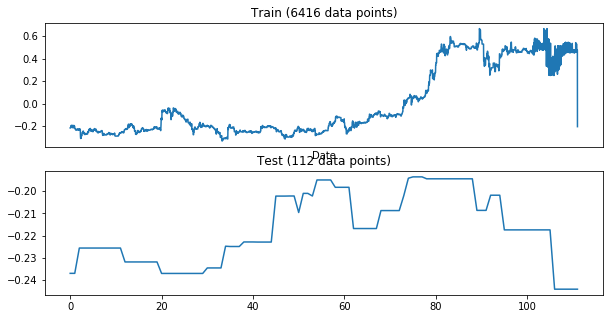

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(2,1, figsize = (10,5))
ax[0].plot(xTrain[:,0])
ax[0].set_title('Train (' +str(len(xTrain))+' data points)')
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

ax[1].plot(xTest[:,0])
ax[1].set_title('Test (' +str(len(xTest))+' data points)')

# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,0])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.xaxis.set_major_locator(mdates.MonthLocator())
# plt.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

plt.show()

# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [52]:
# LOAD DATA^

In [53]:
# SETUP NET

In [54]:
tf.reset_default_graph()


In [55]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [56]:
# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [57]:
# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)


In [58]:
# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [59]:
# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])


In [60]:
# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [61]:
# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [62]:
prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


In [64]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 1
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.065887
Step 50 - Loss: 0.006831
Step 100 - Loss: 0.004447
Step 150 - Loss: 0.000008
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000220
Step 300 - Loss: 0.000220
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000634
Step 450 - Loss: 0.000017
Step 500 - Loss: 0.000057
Step 550 - Loss: 0.000026
Step 600 - Loss: 0.000003
Step 650 - Loss: 0.000133
Step 700 - Loss: 0.000099
Step 750 - Loss: 0.000008
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000078
Step 950 - Loss: 0.000068
Step 1000 - Loss: 0.000079
Step 1050 - Loss: 0.000314
Step 1100 - Loss: 0.000015
Step 1150 - Loss: 0.000064
Step 1200 - Loss: 0.000231
Step 1250 - Loss: 0.000030
Step 1300 - Loss: 0.000164
Step 1350 - Loss: 0.000030
Step 1400 - Loss: 0.000089
Step 1450 - Loss: 0.000112
Step 1500 - Loss: 0.000831
Step 1550 - Loss: 0.000439
Step 1600 - Loss: 0.000174
Step 1650 - Loss: 0.000002
Step 1700 - Loss: 0.000020
Step 1750 - Loss: 0.000247
Step 1800 - Loss: 0.000083
Step 1850 - Loss

ValueError: cannot reshape array of size 8 into shape (1,3,4)

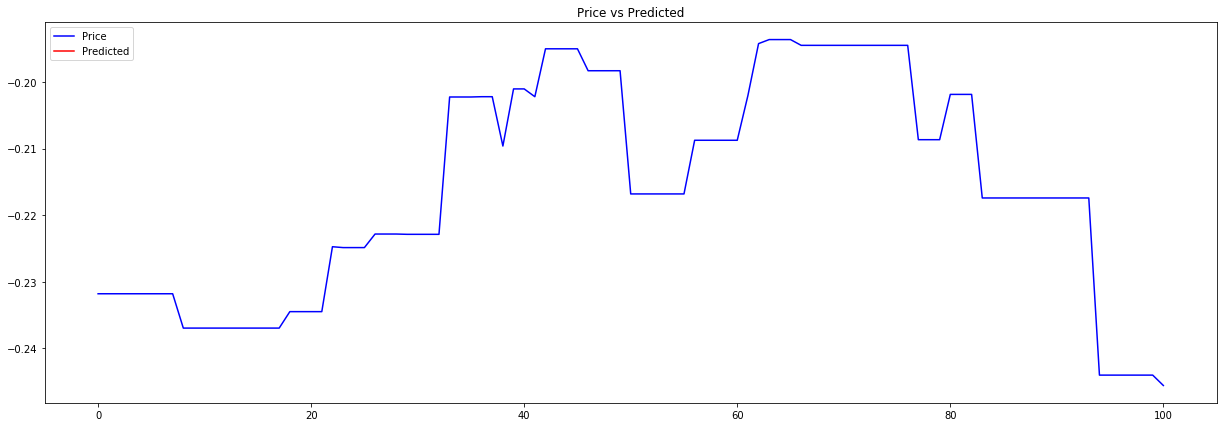

In [25]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()